# Importation

In [35]:
# import dataiku # comment if not working in Dataiku
import pandas as pd
import numpy as np
if not hasattr(np, 'unicode_'):
    np.unicode_ = str
import json
import math
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.signal import chirp, find_peaks, peak_widths

In [2]:
cosmicai_path = 'Data' # replace with your data path, if not in Dataiku

df = pd.read_parquet(f'{cosmicai_path}/bandpass_qa0_no_partitions.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114354 entries, 0 to 114353
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   eb_uid               114354 non-null  object             
 1   cal_data_id          114354 non-null  object             
 2   cal_reduction_id     114354 non-null  object             
 3   start_valid_time     114354 non-null  datetime64[ns, UTC]
 4   receiver_band        114354 non-null  object             
 5   ref_antenna_name     114354 non-null  object             
 6   antenna              114354 non-null  object             
 7   polarization         114354 non-null  object             
 8   sideband             114354 non-null  object             
 9   baseband_name        114354 non-null  object             
 10  spw_name             114354 non-null  object             
 11  frequency_array      114354 non-null  object             
 12  am

| N    |  Column Name             | Description   |              
| :--- | :----                    |          ---: |
| 0    | eb_uid              | Unique ID for one execution |
| 1    | cal_data_id         | Calibration Data ID  |             
| 2    | cal_reduction_id    | Calibration Reduction ID |
| 3    | start_valid_time    | Start Time for a bandpass observation |
| 4    | receiver_band       | ALMA Band used |
| 5    | ref_antenna_name    | Reference Antenna used for Bandpass calculation |       
| 6    | antenna             | Antenna for which the Bandpass solution is produced |
| 7    | polarization        | Reciever Polarization |
| 8    | sideband            | Reciever Sideband |
| 9    | baseband_name       | Baseband Name |
| 10   | spw_name            | Spectral Window Name |
| 11   | frequency_array     | Array with frequency dimension, Hz |
| 12   | amplitude_corr_tsys | Array with the amplitude dimension, corrected by Tsys (units?) |
| 13   | phase_norm_wrap     | Array with the phase dimension, normalized and wrapped, in radians |

In [4]:
df.head(10)

,eb_uid,cal_data_id,cal_reduction_id,start_valid_time,receiver_band,ref_antenna_name,antenna,polarization,sideband,baseband_name,spw_name,frequency_array,amplitude_corr_tsys,phase_norm_wrap
0,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA41,X,LSB,BB_1,SpectralWindow_68,"[351724225880.5871, 351708600880.5871, 3516929...","[0.014256122636602484, 0.014731913342933525, 0...","[-0.06451911942250001, -0.0617732094225, -0.00..."
1,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA41,Y,LSB,BB_1,SpectralWindow_68,"[351724225880.5871, 351708600880.5871, 3516929...","[0.013380656345701562, 0.014427262421258363, 0...","[-0.06347614638691666, -0.01566072838691667, -..."
2,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA42,X,LSB,BB_1,SpectralWindow_68,"[351724225880.5871, 351708600880.5871, 3516929...","[0.014431147004386208, 0.013925552020024039, 0...","[-0.2176890534425, -0.22305674344249998, -0.19..."
3,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA42,Y,LSB,BB_1,SpectralWindow_68,"[351724225880.5871, 351708600880.5871, 3516929...","[0.01401435387584803, 0.014249317856180726, 0....","[0.03815305532075, 0.06564197832074999, 0.0391..."
4,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA43,X,LSB,BB_1,SpectralWindow_68,"[351724225880.5871, 351708600880.5871, 3516929...","[0.014949316205388486, 0.015328749924888039, 0...","[-0.13109463273738334, -0.18370725273738334, -..."
5,uid://A002/X1060272/X3967,CalData_4,CalReduction_4,2023-04-23 07:15:08.112000+00:00,ALMA_RB_06,CM01,CM12,Y,LSB,BB_2,SpectralWindow_18,"[219622562580.63995, 219622440510.32745, 21962...","[0.045857551765094956, 0.03614319890208038, 0....","[0.041184829492187575, -0.05914217050781248, 0..."
6,uid://A002/X1060272/X3967,CalData_4,CalReduction_4,2023-04-23 07:15:08.112000+00:00,ALMA_RB_06,CM01,CM12,Y,LSB,BB_2,SpectralWindow_20,"[220460941486.88995, 220460819416.57745, 22046...","[0.0401227444928091, 0.04233363151397702, 0.03...","[-0.029673094921874907, 0.06457170507812489, 0..."
7,uid://A002/X1060272/X3967,CalData_4,CalReduction_4,2023-04-23 07:15:08.112000+00:00,ALMA_RB_06,CM01,CM01,X,USB,BB_3,SpectralWindow_22,"[230539417840.0637, 230539478875.21994, 230539...","[0.03314203156886907, 0.03199532478149819, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA43,Y,LSB,BB_1,SpectralWindow_68,"[351724225880.5871, 351708600880.5871, 3516929...","[0.01490487109608887, 0.01510182558336035, 0.0...","[-0.16930026337416668, -0.13606859337416666, -..."
9,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA44,X,LSB,BB_1,SpectralWindow_68,"[351724225880.5871, 351708600880.5871, 3516929...","[0.015536372678635918, 0.014857486677088527, 0...","[-0.21134714639021668, -0.26473911639021663, -..."


# Demonstration

In [ ]:
bandpass_sel_df = df.query('eb_uid == "uid://A002/Xff45a6/X4435"').copy()

In [ ]:
fig1 = px.scatter(
    x = bandpass_sel_df.iloc[0]['frequency_array'],
    y = bandpass_sel_df.iloc[0]['amplitude_corr_tsys'],
    render_mode='webgl', range_y=[0, 0.02], 
    labels={'x': 'Frequency [Hz]', 'y': 'Amplitude [?]'}
)
fig1

In [ ]:
fig1 = px.scatter(
    x = bandpass_sel_df.iloc[20]['frequency_array'],
    y = bandpass_sel_df.iloc[20]['phase_norm_wrap'],
    render_mode='webgl', range_y=[-np.pi, np.pi], 
    labels={'x': 'Frequency [Hz]', 'y': 'Phase [rad]'}
)
fig1

In [ ]:
bandpass_explode_df = bandpass_sel_df.explode(['frequency_array','amplitude_corr_tsys','phase_norm_wrap'])

bandpass_explode_df['label'] = bandpass_explode_df.apply(
    lambda x: f'{x["antenna"]}, {x["spw_name"]}, pol {x["polarization"]}', axis=1)

In [ ]:
fig2 = px.scatter(
    bandpass_explode_df,
    x='frequency_array', 
    y='amplitude_corr_tsys',
    color='label', render_mode='webgl',
)
fig2.update_traces(mode='lines', opacity=0.5)

In [ ]:
fig2 = px.line(
    bandpass_explode_df.query('antenna == ["DV24", "DA46", "DV09"] and spw_name == "SpectralWindow_68"'),
    x='frequency_array', 
    y='amplitude_corr_tsys',
    color='label', render_mode='webgl'
)
fig2

In [ ]:
fig2 = px.line(
    bandpass_explode_df.query('antenna == "DA64"'),
    x='frequency_array', 
    y='amplitude_corr_tsys',
    color='label', render_mode='webgl'
)
fig2

In [ ]:
fig2 = px.line(
    bandpass_explode_df.query('antenna == "DV09"'),
    x='frequency_array', 
    y='amplitude_corr_tsys',
    color='label', render_mode='webgl'
)
fig2

In [ ]:
fig2 = px.line(
    bandpass_explode_df.query('antenna == "DA59"'),
    x='frequency_array', 
    y='amplitude_corr_tsys',
    color='label', render_mode='webgl'
)
fig2

In [ ]:
fig2 = px.line(
    bandpass_explode_df.query('antenna == ["DA61", "DV03"]'),
    x='frequency_array', 
    y='phase_norm_wrap',
    color='label', render_mode='webgl'
)
fig2

# Experimentation

In [5]:
trans_df = pd.read_parquet(f'{cosmicai_path}/full_spectrum.gzip')

In [6]:
df['frequency_array'] = df['frequency_array'] \
    .apply(lambda freqs: [f/1e9 for f in freqs])

In [7]:
df['frequency_array']

0         [351.7242258805871, 351.7086008805871, 351.692...
1         [351.7242258805871, 351.7086008805871, 351.692...
2         [351.7242258805871, 351.7086008805871, 351.692...
3         [351.7242258805871, 351.7086008805871, 351.692...
4         [351.7242258805871, 351.7086008805871, 351.692...
                                ...                        
114349    [233.54772872615132, 233.54870528865132, 233.5...
114350    [233.54772872615132, 233.54870528865132, 233.5...
114351    [233.54772872615132, 233.54870528865132, 233.5...
114352    [233.54772872615132, 233.54870528865132, 233.5...
114353    [233.54772872615132, 233.54870528865132, 233.5...
Name: frequency_array, Length: 114354, dtype: object

In [8]:
trans_freqs = trans_df['Frequency (GHz)'].values
trans_vals  = trans_df['Transmission (%)'].values

In [9]:
def match_and_correct(freq_array):
    idxs = np.searchsorted(trans_freqs, freq_array)
    idxs[idxs == len(trans_freqs)] = len(trans_freqs) - 1
    left  = np.maximum(idxs - 1, 0)
    right = idxs
    dl = np.abs(freq_array - trans_freqs[left])
    dr = np.abs(trans_freqs[right] - freq_array)
    nearest = np.where(dl <= dr, left, right)
    mt = trans_vals[nearest]
    return mt

In [10]:
results = df.apply(
    lambda row: match_and_correct(
        np.array(row['frequency_array'], dtype=float)
    ),
    axis=1
)

In [11]:
df['transmission_array'] = results

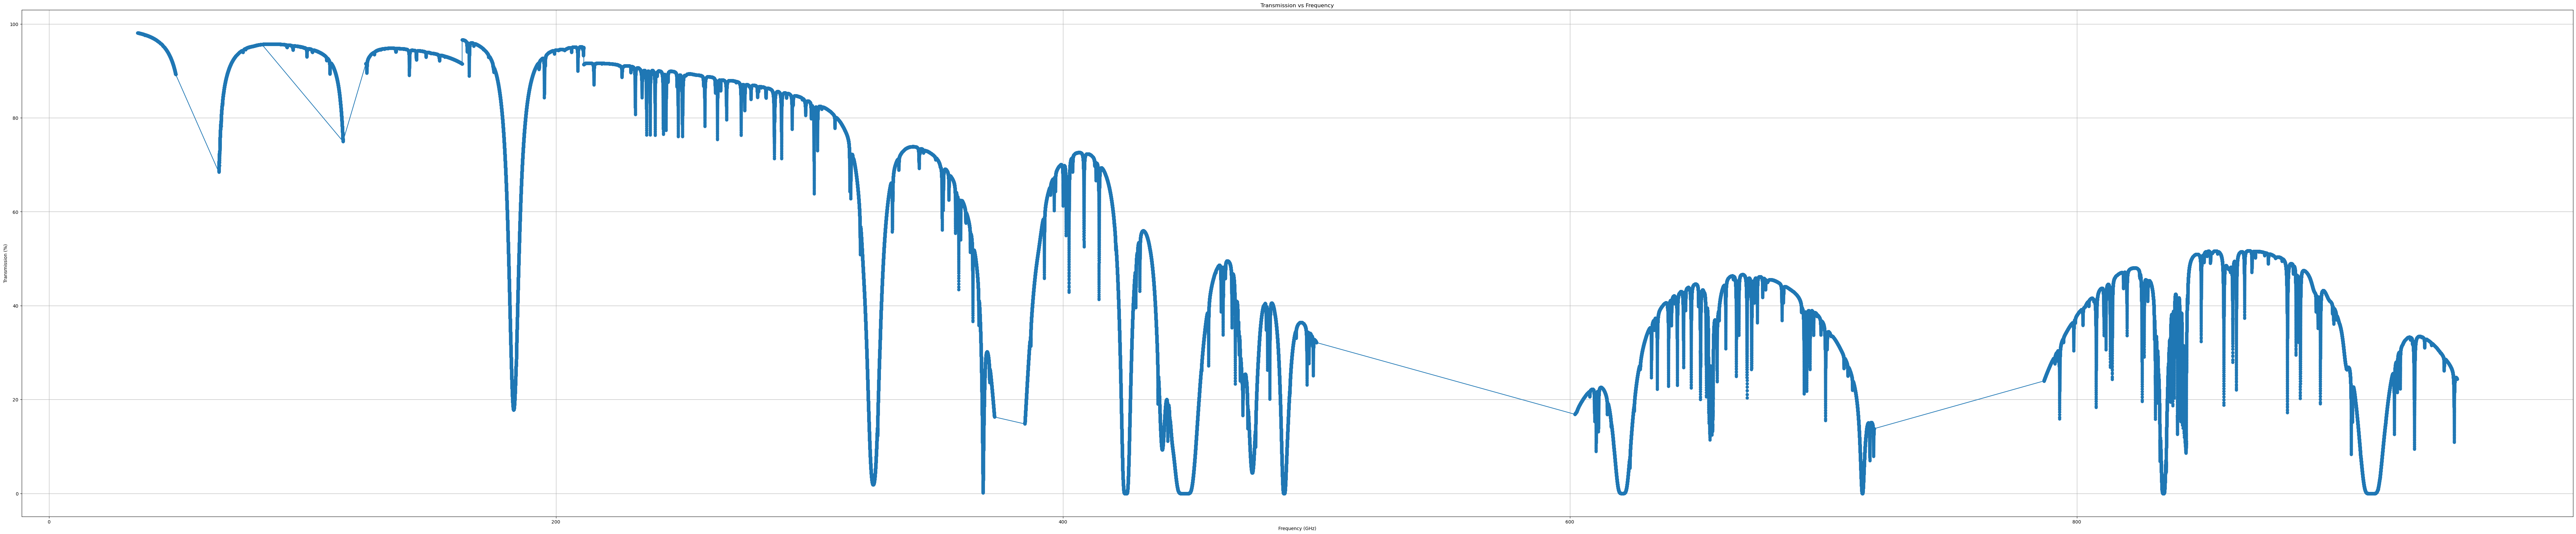

In [12]:
plt.figure(figsize=(100, 20))
plt.plot(trans_freqs, trans_vals, marker='o')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission (%)')
plt.title('Transmission vs Frequency')
plt.grid(True)
plt.show()

In [19]:
interference = []
for index in range(len(df)):
    freqs = np.array(df.iloc[index, 11])
    trans = np.array(df.iloc[index, 14])

    troguhs, props = find_peaks(-trans, prominence=1)
    widths_samples, _, left_ips, right_ips = peak_widths(-trans, troguhs, rel_height=0.75)

    left_freqs  = np.interp(left_ips,  np.arange(len(freqs)), freqs)
    right_freqs = np.interp(right_ips, np.arange(len(freqs)), freqs)
    widths_freq = right_freqs - left_freqs

    trough_freqs  = freqs[troguhs]
    trough_depths = props['prominences']

    trough_ranges = []
    for i in range(len(trough_freqs)):
        trough_ranges.append((trough_freqs[i] - widths_freq[i] / 2, trough_freqs[i] + widths_freq[i] / 2))

    trough_ranges = np.array(trough_ranges)

    closest_idxs = []

    for troguhs_range in trough_ranges:
        start, end = troguhs_range[0], troguhs_range[1]
        closest_start_idx = int(np.abs(freqs - start).argmin())
        closest_end_idx = int(np.abs(freqs - end).argmin())
        closest_idxs.append((closest_start_idx, closest_end_idx))

    interference.append(closest_idxs)

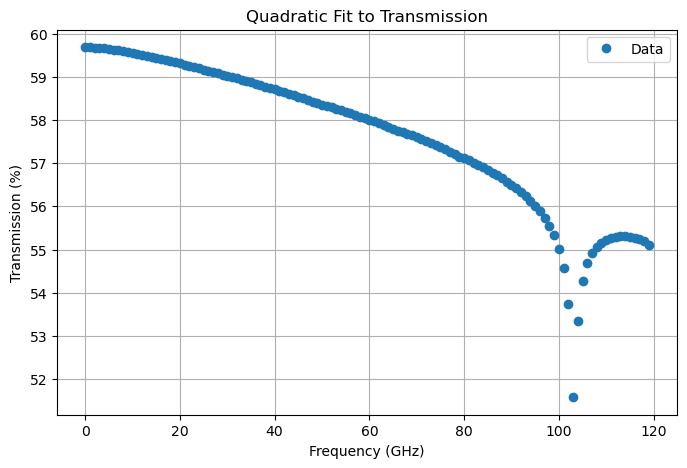

In [25]:
index = 300
freqs = np.array(df.iloc[index, 11])
trans = np.array(df.iloc[index, 14])
# coeffs = np.polyfit(freqs, trans, 2)
# poly = np.poly1d(coeffs)
# fitted = poly(freqs)

plt.figure(figsize=(8,5))
plt.plot(range(len(freqs)), trans, 'o', label='Data')
# plt.plot(freqs, fitted, '-', label='Degree-3 fit')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission (%)')
plt.title('Quadratic Fit to Transmission')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
peaks_df = pd.read_parquet(f'{cosmicai_path}/all_peaks_widths_heights.gzip')

In [ ]:
peaks  = peaks_df['Peaks (GHz)'].values
widths = peaks_df['Widths'].values
peak_ranges = np.column_stack((peaks - widths / 2, peaks + widths / 2))
peak_ranges_mid_points = np.array([float(start + end) / 2 for start, end in peak_ranges])

In [ ]:
freq_ranges = np.array([
    [float(min(x)), float(max(x))]
    for x in df['frequency_array'].tolist()
])
freq_ranges_mid_points = np.array([float(start + end) / 2 for start, end in freq_ranges])

In [ ]:
for idx, freq_points in enumerate(freq_ranges_mid_points):
    closest_idx = int(np.abs(peak_ranges_mid_points - freq_points).argmin())
    freqs = freq_ranges[idx]
    peaks = peak_ranges[closest_idx]
    start = max(freqs[0], peaks[0])
    end   = min(freqs[1], peaks[1])

In [20]:
df['atmospheric_interference'] = interference

In [37]:
df.to_csv(
    f'{cosmicai_path}/bandpass_augmented.csv',
    index=False
)